In [12]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import random
import mpmath
from scipy.stats import norm , poisson
from IPython.display import clear_output, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [13]:
def find_psi(p, Lambda, r, vol, eta_p, eta_m, q_p):
#     solve for psi 
    p = eval(mpmath.nstr(p))
    alpha = q_p / (1 - eta_p) + (1 - q_p) / (1 + eta_m) - 1
    mu = r - Lambda * alpha - 1 / 2 * vol ** 2
    a = (vol ** 2) * eta_m * eta_p / 2
    b = mu * eta_m * eta_p - 1 / 2 * vol ** 2 * (eta_m - eta_p)
    c = -(vol ** 2 / 2 + mu * (eta_m - eta_p) + (r + p + Lambda) * eta_p * eta_m)
    d = (-mu + (r + p + Lambda) * (eta_m - eta_p) - Lambda * (q_p * eta_m - (1 - q_p) * eta_p))
    e = r + p 
    roots = sorted(np.roots([a, b, c, d, e]), reverse=True)
    return roots

def U(p, St, Lambda, r, vol, eta_p, eta_m, q_p, k):  
#     price of binary call in laplace domain 
    roots = find_psi(p, Lambda, r, vol, eta_p, eta_m, q_p)
    a = np.array([[1, 1, -1, -1],
                  [roots[0], roots[1], -roots[2], -roots[3]],
                  [1/(roots[0]*eta_m+1), 1/(roots[1]*eta_m+1), -1/(roots[2]*eta_m+1), -1/(roots[3]*eta_m+1)],
                  [1/(roots[0]*eta_p-1), 1/(roots[1]*eta_p-1), -1/(roots[2]*eta_p-1), -1/(roots[3]*eta_p-1)]])
    b = np.array([float(( 1 / (r + p))), 0, float(( 1 / (r + p) )), float((-1 / (r + p) ))])
    C = np.linalg.solve(a, b)
    x = np.log(St/k)
    if x<0:
        return C[0] * np.exp(roots[0] * x) + C[1] * np.exp(roots[1]*x)
    else: 
        return C[2] * np.exp(roots[2] * x) + C[3] * np.exp(roots[3]*x) + 1/(r+p)

def V(tau, St, Lambda, r, vol, eta_p, eta_m, q_p, k):
    # invere laplace to get price of binary call 
    def U_tau(p):
        return U(p, St, Lambda, r, vol, eta_p, eta_m, q_p, k)

    return mpmath.invertlaplace(U_tau, tau, method='stehfest', degree=8)

def calculate_probability(St, index, time, k):
#     returns prob for binary call on dex
    r = 0 
    index_values = {
        'DEX U900': (0.30/100, 0.04/100, 0.2, 0.25, 175200),
        'DEX D900': (0.04/100, 0.30/100, 0.8, 0.25, 175200),
        'DEX D600': (0.04/100, 0.20/100, 0.8, 0.2, 30*24*365),
        'DEX U600': (0.2/100, 0.04/100, 0.2, 0.2, 30*24*365),
        'DEX D1500': (0.04/100, 0.2/100, 0.6, 0.1, 6*24*365),
        'DEX U1500': (0.2/100, 0.04/100, 0.4, 0.1, 6*24*365)
    }
    eta_p, eta_m, q_p, vol, Lambda = index_values.get(index, (None, None, None, None, None))
    tau = time / 365 / 24 / 60 / 60
    proba = np.abs(V(tau, St, Lambda, r, vol, eta_p, eta_m, q_p, k))
    return proba

In [14]:
def mgf_jump(q,eta_p,eta_n,t=0):
    return q/(1-t*eta_p)+(1-q)/(1+t*eta_n)
def inv_J_cdf_mv(cdf,q,eta_p,eta_n):
    if cdf<1-q:
        return eta_n*np.log(cdf/(1-q))
    else:
        return -eta_p*np.log((1-cdf)/(q)) 
def inv_J_cdf_perl(cdf,q,eta_p,eta_n):
    n = np.random.uniform()
    if cdf<q:
        return -(eta_p*np.log(1-n))
    # Negative jump
    else:
        return eta_n*np.log(1-n)
def DEX_sim(index,cdf,n, S0=10000):
#     generate dex path for mc price
    dt = 1/365/86400
    mu = 0  
    if index == 'DEX U900':
        eta_p = 0.30/100
        eta_n = 0.04/100
        q = 0.2
        vol = 0.25
        decay = 175200
    elif index == 'DEX D900':
        eta_p = 0.04/100
        eta_n = 0.30/100
        q = 0.8
        vol = 0.25
        decay = 175200
    elif index == 'DEX D600':
        eta_p = 0.04/100
        eta_n = 0.20/100
        q = 0.8
        vol = 0.2
        decay = 30*24*365
    elif index == 'DEX U600':
        eta_p = 0.2/100
        eta_n = 0.04/100
        q = 0.2
        vol = 0.2
        decay = 30*24*365
    elif index == 'DEX D1500':
        eta_p = 0.04/100
        eta_n = 0.2/100
        q = 0.6
        vol = 0.1
        decay = 6*24*365
    elif index == 'DEX U1500':
        eta_p = 0.2/100
        eta_n = 0.04/100
        q = 0.4
        vol = 0.1
        decay = 6*24*365
    a=mgf_jump(q,eta_p,eta_n,t=1)-1
    
    S=np.zeros(n+1)
    W = np.random.normal(size=n)
    N = np.random.poisson(decay*dt,size=n)
    S[0] = 1
    S[1:]=np.exp((mu-vol**2/2-decay*a)*dt+vol*np.sqrt(dt)*W)

    for i in range(n):
        if N[i]>0:
            for j in range(N[i]):
                J = cdf(np.random.uniform(),q,eta_p,eta_n)
                S[i+1]*=np.exp(J)    

    S=S.cumprod()
    return S*S0

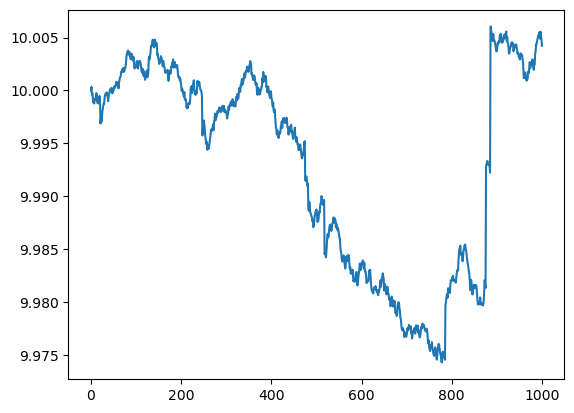

In [15]:
S_down_mv=DEX_sim("DEX U600",cdf=inv_J_cdf_mv,n=1000, S0=10)
plt.plot(S_down_mv);

In [16]:
def mc_price (index, S, K, ticks, runs):
#     returns prob higher than or lower than k
    higher = 0
    for i in range(runs):
        path = DEX_sim(index,cdf=inv_J_cdf_mv,n=ticks, S0=S) 
        higher += 1 if path[-1] > K else 0
    prob_higher = higher/runs
    prob_lower = 1 - prob_higher
    return round(prob_higher,10), round( prob_lower, 10)

In [17]:
St = 10000
k = 10000
time = 3600
index = 'DEX U600'
float(calculate_probability(St, index, time, k))

0.4578596909304906

In [21]:
mc_price(index, S=St, K=k, ticks=time, runs=50000)[0]

0.45742

In [8]:
to_price = pd.DataFrame(columns=['index', 'mc_runs', 'S0','K','ticks', 'mc_higher'])
to_price 

,index,mc_runs,S0,K,ticks,mc_higher


In [14]:
to_price = pd.DataFrame(columns=['index', 'mc_runs', 'S0','K','ticks', 'mc_higher'])
# num_contracts=500
mc_runs = 10000
for index in ['DEX U900','DEX D900','DEX D600','DEX U600','DEX D1500','DEX U1500']:
#     index = random.choice(['DEX U900','DEX D900','DEX D600','DEX U600','DEX D1500','DEX U1500'])
    S = 10000
#     K = round(S*random.uniform(0.8,1.2),2)
    for K2 in [0.98, 0.99, 0.995, 0.9990, 1, 1.001 , 1.005, 1.01, 1.02]:
        for ticks in [300,15*60,3600,7200,3600*5]:
#             ticks = random.randint(1,86400)
            K = round(S*K2,2)
            probs=mc_price(index, S, K, ticks, runs=mc_runs)
            print(index, S, K, ticks)
            to_price.loc[len(to_price)] = index, mc_runs, S, K, ticks, probs[0]   
            clear_output(wait=True)

DEX U1500 10000 10200.0 18000


In [15]:
to_price

,index,mc_runs,S0,K,ticks,mc_higher
0,DEX U900,10000,10000,9800.0,300,1.0000
1,DEX U900,10000,10000,9800.0,900,1.0000
2,DEX U900,10000,10000,9800.0,3600,0.9985
3,DEX U900,10000,10000,9800.0,7200,0.9619
4,DEX U900,10000,10000,9800.0,18000,0.8361
...,...,...,...,...,...,...
265,DEX U1500,10000,10000,10200.0,300,0.0000
266,DEX U1500,10000,10000,10200.0,900,0.0001
267,DEX U1500,10000,10000,10200.0,3600,0.0021
268,DEX U1500,10000,10000,10200.0,7200,0.0080


to_price.to_csv('to_price3.csv',index=False)

### Scenarios

In [12]:
St = 10000
k = 10000
r = 0
Lambda = 365*24*20
q_p = 0.8
eta_p = 0.04/100
eta_m = 0.3/100
vol = 0.25
time = 3600
float(calculate_probability(St, Lambda, r, vol, eta_p, eta_m, q_p, time, k))

0.5551049080095254

In [13]:
St = 10000
k = 10000
r = 0
Lambda = 365*24
q_p = 0.5
eta_p = 0.3/100
eta_m = 0.3/100
vol = 0.1
time = 3600
float(calculate_probability(St, Lambda, r, vol, eta_p, eta_m, q_p, time, k))

0.49805209441592524

In [14]:
St = 10000
k = 10000
r = 0
Lambda = 365*24
q_p = 0.5
eta_p = 0.3/100
eta_m = 0.03/100
vol = 0.1
time = 3600
float(calculate_probability(St, Lambda, r, vol, eta_p, eta_m, q_p, time, k))

0.325354930172125

In [15]:
St = 10000
k = 10000
r = 0
Lambda = 365*24*10
q_p = 0.3
eta_p = 0.2/100
eta_m = 0.05/100
vol = 0.1
time = 60 * 60 * 24
float(calculate_probability(St, Lambda, r, vol, eta_p, eta_m, q_p, time, k))

0.48247759977994065

In [16]:
St = 10000
k = 10000
r = 0
Lambda = 365*24*60
q_p = 0.5
eta_p = 0.05/100
eta_m = 0.05/100
vol = 0.1
time = 60*10
float(calculate_probability(St, Lambda, r, vol, eta_p, eta_m, q_p, time, k))

0.4995071200764869

In [17]:
St = 10000
k = 10000
r = 0
Lambda = 365*24*60*2
q_p = 0.7
eta_p = 0.01/100
eta_m = 0.1/100
vol = 0.5
time = 60*10
float(calculate_probability(St, Lambda, r, vol, eta_p, eta_m, q_p, time, k))

0.5333416076182402